First few rows of a.csv:
            Bean_Kandy_price
Date                        
2020-01-01              95.0
2020-01-02              95.0
2020-01-03              95.0
2020-01-04              95.0
2020-01-05              95.0

First few rows of the merged and filtered dataframe:
            Bean_Kandy_price  rain_sum
Date                                  
2020-01-01              95.0       0.4
2020-01-02              95.0       0.2
2020-01-03              95.0       0.0
2020-01-04              95.0       0.2
2020-01-05              95.0       0.0
Column names in df_merged: Index(['Bean_Kandy_price', 'rain_sum'], dtype='object')
Filtered CSV file 'beans-dollar.csv' has been created.


c:\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 0.0330 - val_loss: 0.0185
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0163 - val_loss: 0.0230
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0153 - val_loss: 0.0153
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0119 - val_loss: 0.0169
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0113 - val_loss: 0.0125
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0097 - val_loss: 0.0125
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0089 - val_loss: 0.0127
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0112 - val_loss: 0.0098
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0095 - val_loss: 0.0101
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0103 - val_loss: 0.0112
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0086 - val_loss: 0.0081
Epoch 12/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0

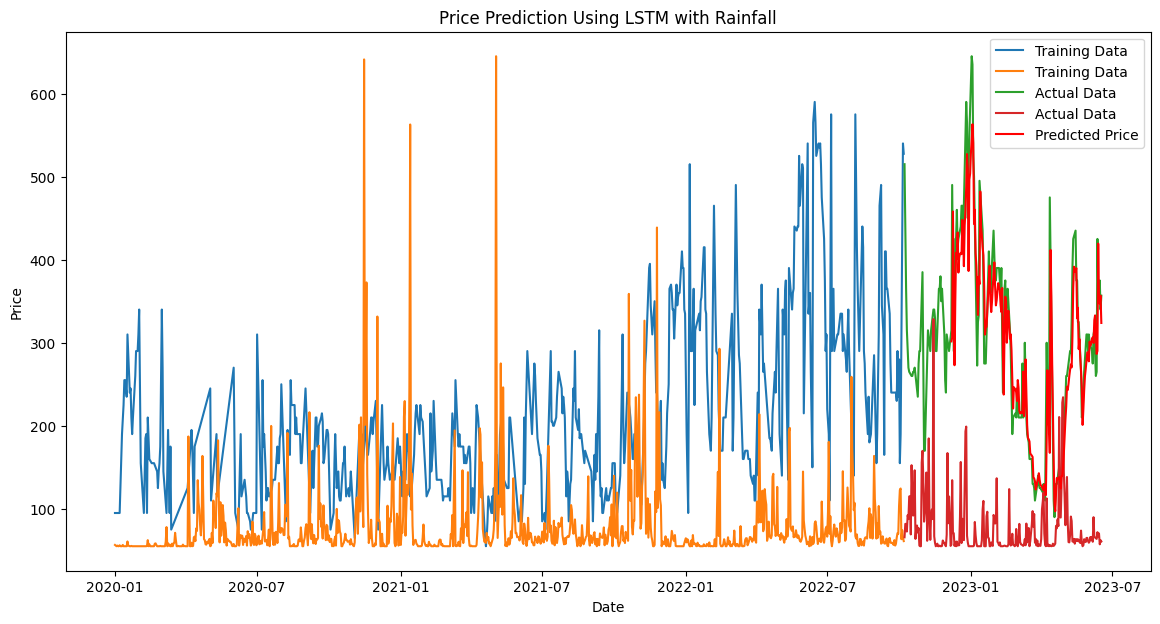

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
df_a = pd.read_csv('bean-interpolated.csv', parse_dates=['Date'], index_col='Date')

# Load the data from dollar-carrot.csv
df_weather_kandy = pd.read_csv('Weather_Kandy.csv', parse_dates=['Date'], index_col='Date')
# Display the first few rows of the dataframes
print("First few rows of a.csv:")
print(df_a.head())


# Merge the dataframes on the 'date' column
# Assuming 'dollar-carrot.csv' contains columns such as 'dollar_rate_carrot' or similar to avoid naming conflicts
df_merged = df_a.merge(df_weather_kandy, on='Date', how='inner')

# Display the first few rows of the merged and filtered dataframe
print("\nFirst few rows of the merged and filtered dataframe:")
print(df_merged.head())

# Display the column names of the merged dataframe
print("Column names in df_merged:", df_merged.columns)

# Save the filtered dataframe to 'beans-dollar.csv'
# df_merged.to_csv('beannnns-dollar.csv', index=False)

print("Filtered CSV file 'beans-dollar.csv' has been created.")

df = df_merged
from sklearn.preprocessing import MinMaxScaler

# Scale the data
scaler_price = MinMaxScaler(feature_range=(0, 1))
scaler_dollar = MinMaxScaler(feature_range=(0, 1))

df['Bean_Kandy_price'] = scaler_price.fit_transform(df[['Bean_Kandy_price']])
df['rain_sum'] = scaler_dollar.fit_transform(df[['rain_sum']])

# Create training and testing datasets
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]
import numpy as np
def create_dataset(data, look_back=1):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), :])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)

# Using the last 60 days to predict the next day's price
look_back = 60
X_train, y_train = create_dataset(train.values, look_back)
X_test, y_test = create_dataset(test.values, look_back)

# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 2))  # 2 features: price and dollar rate
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 2))
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(look_back, 2)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))
# Predict using the trained model
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Invert predictions and actual values from scaled form back to original prices
train_predictions = scaler_price.inverse_transform(train_predictions)
y_train_actual = scaler_price.inverse_transform([y_train])
test_predictions = scaler_price.inverse_transform(test_predictions)
y_test_actual = scaler_price.inverse_transform([y_test])


from sklearn.metrics import mean_squared_error, mean_squared_log_error


y_test_actual_flat = y_test_actual.flatten()
test_predictions_flat = test_predictions.flatten()

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test_actual_flat, test_predictions_flat)
print(f'Mean Squared Error (MSE): {mse}')

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Calculate Root Mean Squared Logarithmic Error (RMSLE)
y_test_actual_flat_safe = np.maximum(y_test_actual_flat, 1e-10)
test_predictions_flat_safe = np.maximum(test_predictions_flat, 1e-10)

rmsle = np.sqrt(mean_squared_log_error(y_test_actual_flat_safe, test_predictions_flat_safe))
print(f'Root Mean Squared Logarithmic Error (RMSLE): {rmsle}')
percentage_errors = np.abs((y_test_actual_flat - test_predictions_flat) / y_test_actual_flat) * 100

# Calculate mean percentage error
mean_percentage_error = np.mean(percentage_errors)
print(f'Mean Percentage Error (MPE): {mean_percentage_error:.2f}%')

# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
filtered_index_train = df.index[:train_size][df.index[:train_size] >= '2020-01-01']
filtered_index_test = df.index[train_size:][df.index[train_size:] >= '2020-01-01']
filtered_index_predictions = df.index[train_size+look_back:][df.index[train_size+look_back:] >= '2020-01-01']

plt.plot(filtered_index_train, scaler_price.inverse_transform(train.values), label='Training Data')
plt.plot(filtered_index_test, scaler_price.inverse_transform(test.values), label='Actual Data')
plt.plot(filtered_index_predictions, test_predictions, label='Predicted Price', color='red')

# filtered_index_train = df.index[:train_size][df.index[:train_size] >= '2020-01-01']
# filtered_index_test = df.index[train_size:][df.index[train_size:] >= '2020-01-01']
# filtered_index_predictions = df.index[train_size+look_back:][df.index[train_size+look_back:] >= '2020-01-01']

# plt.plot(filtered_index_train, scaler.inverse_transform(train.values[df.index[:train_size] >= '2020-01-01']), label='Training Data')
# plt.plot(filtered_index_test, scaler.inverse_transform(test.values[df.index[train_size:] >= '2020-01-01']), label='Actual Price')
# plt.plot(filtered_index_predictions, test_predictions[df.index[train_size+look_back:] >= '2020-01-01'], label='Predicted Price', color='red')

plt.title('Price Prediction Using LSTM with Rainfall')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()
